# Final Project - Team 10
**Convolutional Neural Networks (CNN) for sentiment analysis**

Source:
[![Portfolio](https://img.shields.io/badge/Portfolio-chriskhanhtran.github.io-blue?logo=GitHub)](https://chriskhanhtran.github.io/)

## Introduction

**Convolutional Neural Networks (CNN)** were originally invented for computer vision (CV) and now are the building block of state-of-the-art CV models. One of the earliest applications of CNN in Natural Language Processing (NLP) was introduced in the paper ***Convolutional Neural Networks for Sentence Classification*** (Kim, 2014). With the same idea as in computer vision, CNN model is used as an feature extractor that encodes semantic features of sentences before these features are fed to a classifier.


With only a simple one-layer CNN trained on top of pretrained word vectors and little hyperparameter tuning, the model achieves excellent results on multiple sentence-level classification tasks. CNN models are now used widely other NLP tasks such as translation or question answering as a part of a more complex architecture.

This project will cover:
- Tokenizing and building vocabuilary from text data
- Loading pretrained word2vec/fastText word vectors and creating embedding layer for fine-tuning
- Building and training CNN model with PyTorch
- Advice for practitioners
- Bonus: Using Skorch as a scikit-like wrapper for PyTorch's Deep Learning models

**Reference:**
-  [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882) (Kim, 2014).
- [A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1510.03820) (Zhang, 2015).
- [Advances in Pre-Training Distributed Word Representations](https://arxiv.org/abs/1712.09405) (Mikolov, 2018).



## 1. Set up

### 1.1. Import Libraries

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import nltk
nltk.download("all")
import matplotlib.pyplot as plt
import torch

%matplotlib inline

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

### 1.2. Download Datasets

The dataset we will use is Movie Review (MR), a sentence polarity dataset from (Pang and Lee, 2005). The dataset has 5331 positive and 5331 negative processed sentences/snippets.

In [ ]:
URL = 'https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'
# Download Datasets
!wget -P 'Data/' $URL
# Unzip
!tar xvzf 'Data/rt-polaritydata.tar.gz' -C 'Data/'

--2022-06-09 13:08:08--  https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487770 (476K) [application/x-gzip]
Saving to: ‘Data/rt-polaritydata.tar.gz’

rt-polaritydata.tar 100%[===================>] 476.34K  1.34MB/s    in 0.3s    

2022-06-09 13:08:09 (1.34 MB/s) - ‘Data/rt-polaritydata.tar.gz’ saved [487770/487770]

rt-polaritydata.README.1.0.txt
rt-polaritydata/rt-polarity.neg
rt-polaritydata/rt-polarity.pos


In [ ]:
def load_text(path):
    """Load text data, lowercase text and save to a list."""

    with open(path, 'rb') as f:
        texts = []
        for line in f:
            texts.append(line.decode(errors='ignore').lower().strip())

    return texts

# Load files
neg_text = load_text('Data/rt-polaritydata/rt-polarity.neg')
pos_text = load_text('Data/rt-polaritydata/rt-polarity.pos')

# Concatenate and label data
texts = np.array(neg_text + pos_text)
labels = np.array([0]*len(neg_text) + [1]*len(pos_text))

###1.3. Download word2vec Word Vectors
The pretrained word vectors used in the original paper is *word2vec* (Mikolov et al., 2013) trained on 100 billion tokens of Google News.

In [ ]:
# Download Word2Vec
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api
import gensim
import os


wv = api.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
for index, word in enumerate(wv.index2word):
    if index == 10:
        break
    print(f"word #{index}/{len(wv.index2word)} is {word}")
print(wv.get_vector("in"))

word #0/3000000 is </s>
word #1/3000000 is in
word #2/3000000 is for
word #3/3000000 is that
word #4/3000000 is is
word #5/3000000 is on
word #6/3000000 is ##
word #7/3000000 is The
word #8/3000000 is with
word #9/3000000 is said
[ 0.0703125   0.08691406  0.08789062  0.0625      0.06933594 -0.10888672
 -0.08154297 -0.15429688  0.02075195  0.13183594 -0.11376953 -0.03735352
  0.06933594  0.078125   -0.10302734 -0.09765625  0.04418945  0.10253906
 -0.06079102 -0.03613281 -0.04541016  0.04736328 -0.12060547 -0.06396484
  0.0022583   0.03710938 -0.00291443  0.11767578  0.06176758  0.06396484
  0.08105469 -0.06884766 -0.0213623   0.05517578 -0.08544922  0.06884766
 -0.12792969 -0.03320312  0.09863281  0.17578125  0.11083984 -0.03466797
 -0.04711914 -0.00848389  0.03588867  0.10302734  0.02697754 -0.02868652
 -0.00512695  0.10644531  0.05981445  0.09423828  0.03369141 -0.02709961
 -0.09423828  0.00102997 -0.04833984  0.03442383  0.08105469 -0.11328125
 -0.08886719  0.03588867 -0.14550781 -0.

### ++ 1.3. Download fastText Word Vectors

We can use [*fastText* pretrained word vectors](https://fasttext.cc/docs/en/english-vectors.html) (Mikolov et al., 2017), trained on 600 billion tokens on Common Crawl. *fastText* is an upgraded version of *word2vec* and outperform other state-of-the-art methods by a large margin.

The code below will download fastText pretrained vectors. Using Google Colab, the running time is approximately 3min 30s.

In [ ]:
%%time
URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
FILE = "fastText"

if os.path.isdir(FILE):
    print("fastText exists.")
else:
    !wget -P $FILE $URL
    !unzip $FILE/crawl-300d-2M.vec.zip -d $FILE

--2022-06-08 13:14:40--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘fastText/crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  43.1MB/s    in 34s     

2022-06-08 13:15:15 (43.0 MB/s) - ‘fastText/crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]

Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  
CPU times: user 605 ms, sys: 256 ms, total: 861 ms
Wall time: 1min 16s


### 1.4. Set up GPU for Training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

> Runtime -> Change runtime type -> Hardware accelerator: GPU

Then we need to run the following cell to specify the GPU as the device.

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


## 2. Data Preparation

To prepare our text data for training, first we need to tokenize our sentences and build a vocabulary dictionary `word2idx`, which will later be used to convert our tokens into indexes and build an embedding layer.

***So, what is an embedding layer?***

An embedding layer serves as a **look-up table** which take word indexes in the vocabulary as input and output word vectors. Hence, the embedding layer has shape $(N, d)$ where $N$ is the size of the vocabulary and $d$ is the embedding dimension. In order to fine-tune pretrained word vectors, we need to create an embedding layer in our `nn.Modules` class. Our input to the model will then be `input_ids`, which is the tokens' index in the vocabulary.

### 2.1. Tokenize

The function `tokenize` will tokenize our sentences, build a vocabulary and fine the maximum sentence length. The function `encode` will take in the outputs of `tokenize`, perform sentence padding and return `input_ids` as a numpy array.

In [ ]:
from nltk.tokenize import word_tokenize
from collections import defaultdict

def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

### 2.2. Load Pretrained Vectors

We will load the pretrain vectors for each tokens in our vocabulary. For tokens with no pretraiend vectors, we will initialize random word vectors with the same length and variance 

For word2vec - Google news 3000

In [ ]:
from tqdm import tqdm_notebook

def load_pretrained_vectors_2(word2idx, wv):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")


    # Initilize random embeddings
    # dimension = 300
    d = 300
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for index, word in enumerate(wv.index2word):
        tokens = wv.get_vector(word)
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens, dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

++ For fastText

In [ ]:
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    print(d)

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

Now let's put above steps together.

This is the result of word2vec

In [ ]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)

# Load pretrained vectors
#embeddings = load_pretrained_vectors(word2idx, "fastText/crawl-300d-2M.vec")
embeddings = load_pretrained_vectors_2(word2idx, wv)
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...
There are 15951 / 20286 pretrained vectors found.


This is the result of fastText

In [ ]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)

# Load pretrained vectors
embeddings_fast = load_pretrained_vectors(word2idx, "fastText/crawl-300d-2M.vec")
embeddings_fast = torch.tensor(embeddings_fast)

Tokenizing...

Loading pretrained vectors...
300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

There are 18526 / 20286 pretrained vectors found.


##We can notice that fastText contains more pre-trained vectors than word2vec, this is due to fastText using sub-string to generate the corresponding word vector. 

### 2.3. Create PyTorch DataLoader

Below are the result using word2vec (same as original setting)

We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed. The batch_size used in the paper is 50.

In [ ]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

We will use 90% of the dataset for training and 10% for validation.

In [ ]:
from sklearn.model_selection import train_test_split

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.1, random_state=42)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = \
data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

## 3. Model

**CNN Architecture**

The picture below is the illustration of the CNN architecture that we are going to build with three filter sizes: 2, 3, and 4, each of which has 2 filters.

![](https://github.com/chriskhanhtran/CNN-Sentence-Classification-PyTorch/blob/master/cnn-architecture.JPG?raw=true)

*CNN Architecture (Source: Zhang, 2015)*

```python
# Sample configuration:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]
```

Suppose that we are classifying the sentence "***I like this movie very much!***" ($N = 7$ tokens) and the dimensionality of word vectors is $d=5$. After applying the embedding layer on the input token ids, the sample sentence is presented as a 2D tensor with shape (7, 5) like an image.

$$\mathrm{x_{emb}} \quad \in \mathbb{R}^{7 \times 5}$$

We then use 1-dimesional convolution to extract features from the sentence. In this example, we have 6 filters in total, and each filter has shape $(f_i, d)$ where $f_i$ is the filter size for $i \in \{1,...,6\}$. Each filter will then scan over $\mathrm{x_{emb}}$ and returns a feature map:

$$\mathrm{x_{conv_ i} = Conv1D(x_{emb})} \quad \in \mathbb{R}^{N-f_i+1}$$

Next, we apply the ReLU activation to $\mathrm{x_{conv_{i}}}$ and use max-over-time-pooling to reduce each feature map to a single scalar. Then we concatenate these scalars into the final feature vector which will be fed to a fully connected layer to compute the final scores for our classes (logits).

$$\mathrm{x_{pool_i} = MaxPool(ReLU(x_{conv_i}))} \quad \in \mathbb{R}$$

$$\mathrm{x_{fc} = \texttt{concat}(x_{pool_i})} \quad \in \mathbb{R}^6$$

The idea here is that each filter will capture different semantic signals in the sentence (ie. happiness, humor, politic, anger...) and max-pooling will record only the strongest signal over the sentence. This logic makes sense because humans also perceive the sentiment of a sentence based on its strongest word/signal.

Finally, we use a fully connected layer with the weight matrix $\mathbf{W_{fc}} \in \mathbb{R}^{2 \times 6} $ and dropout to compute $\mathrm{logits}$, which is a vector of length 2 that keeps the scores for 2 classes.

$$\mathrm{logits = Dropout(\mathbf{W_{fc}}x_{fc})}  \in \mathbb{R}^2$$

An in-depth explanation of CNN can be found in this [article](https://cs231n.github.io/convolutional-networks/) and this [video](https://www.youtube.com/watch?v=YRhxdVk_sIs).










### 3.1. Create CNN Model

For simplicity, the model above has very small configurations. The final model we'll use is much bigger but has the same architecture:

|Description         |Values           |
|:------------------:|:---------------:|
|input word vectors  |Word2Vec         |
|embedding size      |300              |
|filter sizes        |(3, 4, 5)        |
|num filters         |(100, 100, 100)  |
|activation          |ReLU             |
|pooling             |1-max pooling    |
|dropout rate        |0.5              |



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

### 3.2. Optimizer

To train Deep Learning models, we need to define a loss function and minimize this loss. We'll use back-propagation to compute gradients and use an optimization algorithm (ie. Gradient Descent) to minimize the loss. The original paper used the Adadelta optimizer.

In [ ]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=2,
                        dropout=0.5)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

### 3.3. Training Loop

For each epoch, the code below will perform a forward step to compute the *Cross Entropy* loss, a backward step to compute gradients and use the optimizer to update weights/parameters. At the end of each epoch, the loss on training data and the accuracy over the validation data will be printed to help us keep track of the model's performance. The code is heavily annotated with detailed explanations.

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {\
    'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {\
            val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

## 4. Evaluation 

In the original paper, the author tried different variations of the model.
- **CNN-rand**: The baseline model where the embedding layer is randomly initialized and then updated during training.
- **CNN-static**: A model with pretrained vectors. However, the embedding layer is freezed during training.
- **CNN-non-static**: Same as above but the embedding layers are fine-tuned during training.

We will experiment with all 3 variations and compare their performance. Below is the report of our results and the results in the original paper.

|Model            |Kim's results  |Our results  |
|:----------------|:-------------:|:-----------:|
|CNN-rand         |76.1           |74.1        |
|CNN-static       |81.0           |81.5         |
|CNN-non-static   |81.5           |82.3         |




In [ ]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.685476   |  0.651861  |   61.22   |   2.67   
   2    |   0.624468   |  0.615144  |   66.04   |   1.57   
   3    |   0.559012   |  0.575021  |   67.57   |   1.56   
   4    |   0.489456   |  0.558582  |   70.39   |   1.56   
   5    |   0.409995   |  0.545139  |   71.93   |   1.57   
   6    |   0.340754   |  0.547920  |   70.57   |   1.57   
   7    |   0.276044   |  0.529366  |   71.29   |   1.58   
   8    |   0.221420   |  0.525620  |   73.20   |   1.57   
   9    |   0.175291   |  0.559243  |   71.66   |   1.57   
  10    |   0.142128   |  0.541397  |   73.29   |   1.57   
  11    |   0.116149   |  0.557074  |   73.10   |   1.65   
  12    |   0.096489   |  0.567927  |   74.10   |   1.66   
  13    |   0.076263   |  0.593156  |   73.10   |   1.58   
  14    |   0.066050   |  0.637299  |   71.65   |   1.58   
  15    |   0.058042

In [ ]:
# CNN-static: Use embeddind_fast to load fastText pretrained word vectors.
set_seed(42)
cnn_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.25,
                                        dropout=0.5)
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.631564   |  0.536177  |   74.57   |   0.92   
   2    |   0.500753   |  0.464617  |   79.66   |   0.78   
   3    |   0.444290   |  0.445928  |   80.75   |   0.77   
   4    |   0.397549   |  0.433489  |   80.93   |   0.78   
   5    |   0.357537   |  0.431515  |   80.94   |   0.78   
   6    |   0.315548   |  0.431678  |   79.84   |   0.77   
   7    |   0.276134   |  0.426910  |   81.11   |   0.79   
   8    |   0.235768   |  0.432290  |   81.29   |   0.77   
   9    |   0.201406   |  0.482175  |   78.65   |   0.78   
  10    |   0.162555   |  0.442933  |   81.02   |   0.77   
  11    |   0.138555   |  0.454265  |   80.75   |   0.78   
  12    |   0.113997   |  0.472363  |   80.84   |   0.78   
  13    |   0.093692   |  0.493957  |   79.38   |   0.78   
  14    |   0.079443   |  0.487628  |   80.66   |   0.78   
  15    |   0.064189

In [ ]:
# CNN-non-static: pretrained word vectors are fine-tuned during training.
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.630592   |  0.533324  |   74.66   |   2.49   
   2    |   0.495733   |  0.458204  |   79.29   |   2.43   
   3    |   0.431693   |  0.438798  |   80.56   |   2.44   
   4    |   0.375908   |  0.421618  |   81.48   |   2.44   
   5    |   0.327465   |  0.419217  |   81.56   |   2.46   
   6    |   0.278496   |  0.422913  |   81.39   |   2.45   
   7    |   0.230890   |  0.424322  |   81.74   |   2.45   
   8    |   0.185776   |  0.433438  |   81.20   |   2.46   
   9    |   0.148606   |  0.506748  |   78.66   |   2.47   
  10    |   0.112597   |  0.461000  |   81.65   |   2.47   
  11    |   0.089711   |  0.478678  |   81.65   |   2.48   
  12    |   0.070236   |  0.502036  |   81.65   |   2.47   
  13    |   0.053673   |  0.536923  |   81.11   |   2.47   
  14    |   0.043098   |  0.543960  |   82.29   |   2.47   
  15    |   0.034785

## 5. Test Model

Let's test our CNN-non-static model on some examples.

In [ ]:
def predict(text, model=cnn_non_static.to("cpu"), max_len=62):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)

    print(f"This review is {probs[1] * 100:.2f}% positive.")

Our model can easily regconize reviews with strong negative signals. On samples that have mixed feelings but positive sentiment overvall, our model also gets excellent results.

In [ ]:
predict("All of friends slept while watching this movie. But I really enjoyed it.")
predict("I have waited so long for this movie. I am now so satisfied and happy.")
predict("This movie is long and boring.")
predict("I don't like the ending.")

This review is 19.64% positive.
This review is 98.44% positive.
This review is 0.00% positive.
This review is 4.29% positive.


Plot accuracy and loss of the model





In [ ]:
!pip install skorch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, Checkpoint, LoadInitState
from skorch.dataset import CVSplit, Dataset

# Specify validation set
val_dataset = Dataset(val_inputs, val_labels)

# Specify callbacks and checkpoints
cp = Checkpoint(monitor='valid_acc_best', dirname='exp1')
callbacks = [
    ('early_stop', EarlyStopping(monitor='valid_acc', patience=5, lower_is_better=False)),
    cp
]

net = NeuralNetClassifier(
    # Module
    module=CNN_NLP,
    module__pretrained_embedding=embeddings,
    module__freeze_embedding=False,
    module__dropout=0.5,
    # Optimizer
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adadelta,
    optimizer__lr=0.25,
    optimizer__rho=0.95,
    # Others
    max_epochs=20,
    batch_size=50,
    train_split=predefined_split(val_dataset),
    iterator_train__shuffle=True,
    warm_start=False,
    callbacks=callbacks,
    device=device
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 155 kB 4.9 MB/s 


`skorch` also prints training results in a very nice table. My training loop in section 3 is inspired by this format. When model (checkpoints) are saved, you can see the `+` sign in column `cp`.

In [ ]:
set_seed(42)
history = net.fit(np.array(train_inputs), train_labels)

valid_acc_best = np.max(net.history[:, 'valid_acc'])
print(f"Training complete! Best accuracy: {valid_acc_best * 100:.2f}%")

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.6307       0.7479        0.5336     +  2.6498
      2        0.4957       0.7938        0.4571     +  2.6030
      3        0.4317       0.8051        0.4379     +  2.6071
      4        0.3759       0.8163        0.4208     +  2.6105
      5        0.3275       0.8154        0.4183        2.6138
      6        0.2784       0.8172        0.4238     +  2.6171
      7        0.2309       0.8172        0.4238        2.6138
      8        0.1858       0.8116        0.4334        2.6026
      9        0.1486       0.7873        0.5101        2.5993
     10        0.1126       0.8163        0.4621        2.5953
Stopping since valid_acc has not improved in the last 5 epochs.
Training complete! Best accuracy: 81.72%


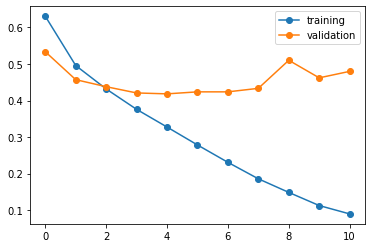

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history[:, 'train_loss']
valid_loss = history.history[:, 'valid_loss']

plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.legend()
plt.show()

As Deep Learning model can overfit the training data, it's important to save our model when it fits our validation data just right. After training, we can load our model from the last checkpoint to make predictions.

In [ ]:
# Load parameters from checkpoint
net.load_params(checkpoint=cp)

predict("All of friends slept while watching this movie. But I really enjoyed it.", model=net)
predict("I have waited so long for this movie. I am now so satisfied and happy.", model=net)
predict("This movie is long and boring.", model=net)
predict("I don't like the ending.", model=net)

This review is 48.40% positive.
This review is 66.33% positive.
This review is 0.32% positive.
This review is 20.15% positive.
